# 1. What is ROC-AUC in the end?

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# create dummy classification problem
X, y = make_classification(n_samples=5_000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10) 

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [2]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression().fit(X_train, y_train)

In [3]:
x = X_train[25,:].reshape(1,-1) 
model_lr.predict(x)

array([1])

### Probabilities? Be careful

In [4]:
model_lr.predict_proba(x)

array([[0.33123002, 0.66876998]])

In [5]:
y_train_pred_lr = model_lr.predict_proba(X_train)[:,1]
y_test_pred_lr = model_lr.predict_proba(X_test)[:,1]

In [6]:
from sklearn.metrics import roc_auc_score

print("Train ROC AUC: {0:.4f}".format(roc_auc_score(y_train, y_train_pred_lr)))
print("Test ROC AUC: {0:.4f}".format(roc_auc_score(y_test, y_test_pred_lr)))

Train ROC AUC: 0.7599
Test ROC AUC: 0.7479


**ROC-AUC is the probability that a sample of the positive class has a score higher than one sample from the negative class.**

In [27]:
import pandas as pd

df = pd.DataFrame({'score': y_test_pred_lr, 'label': y_test})
print(df.head().round(3).to_string())

n_samples = 10000

# randomly sample scores from class 1 and 0
class_1_score_samples = df[df['label']==1]['score'].sample(n_samples, replace=True, random_state=0)
class_0_score_samples = df[df['label']==0]['score'].sample(n_samples, replace=True, random_state=1)

# check the % of cases in which the class 1 score higher
total = (class_1_score_samples.values >= class_0_score_samples.values).mean()

print("-> Percentage of times the score for class 1 was higher than class 0: {0:.1f}%".format(100* total))

   score  label
0  0.501      0
1  0.180      1
2  0.769      1
3  0.328      1
4  0.401      1
-> Percentage of times the score for class 1 was higher than class 0: 74.6%


**Property --> ROC-AUC is invariant to data transformations.**

In [8]:
print("Original test ROC AUC: {0:.4f}".format(roc_auc_score(y_test, y_test_pred_lr)))
print("Applying 10x: {0:.4f}".format(roc_auc_score(10*y_test, 10*y_test_pred_lr)))
print("Applying power of 10: {0:.4f}".format(roc_auc_score(y_test**10, y_test_pred_lr**10)))

Original test ROC AUC: 0.7479
Applying 10x: 0.7479
Applying power of 10: 0.7479


### 1.1 Universal Baseline 

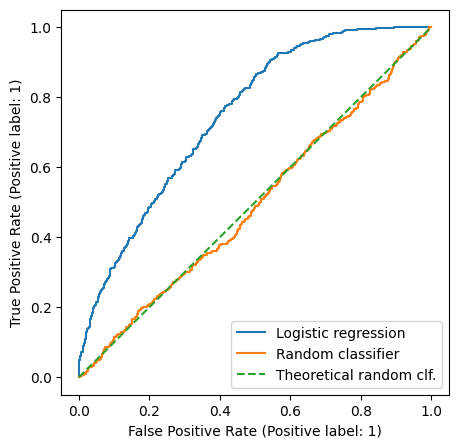

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(5,5))

# completely random classifier, generating random scores between [0,1]
np.random.seed(123)
y_pred_random = np.random.rand(*y_test_pred_lr.shape)

# theoretical random classifier
p = np.linspace(0,1)

RocCurveDisplay.from_predictions(y_test, y_test_pred_lr, ax=ax, label='Logistic regression')
RocCurveDisplay.from_predictions(y_test, y_pred_random, ax=ax, label='Random classifier')
plt.plot(p,p,linestyle='--', label='Theoretical random clf.')
plt.legend()
plt.show()

# 2. Lift Curve 

In [10]:
def build_lift_curve(y_actual, y_pred, 
                     ascending=True,
                     return_ideal_curve=False):
    
    """
    Returns the lift curve from actual (0 or 1) data and
    predicted scores.
    
    Also returns what the ideal lift curve for this problem 
    would be, if return_ideal_curve = True
    """
    
    df = pd.DataFrame({'y_actual': y_actual,
                   'prob_default': y_pred})

    # sort from low to high scores
    df = df.sort_values('prob_default', ascending=ascending)
    
    # build cumulative_default
    df['cumulative_default'] = df['y_actual'].cumsum()
    df['lift'] = df['cumulative_default']/df['y_actual'].sum()

    # create index starting from 0 and normalize
    df = df.reset_index(drop=True).reset_index()
    df['index'] = df['index']/(df['index'].iloc[-1])
    df = df.set_index('index')
    
    if return_ideal_curve:
        df_perfect = df.sort_values('y_actual', ascending=ascending)
        df_perfect['cumulative_default'] = df_perfect['y_actual'].cumsum()
        df_perfect['lift'] = df_perfect['cumulative_default']/df_perfect['cumulative_default'].iloc[-1]
        df_perfect = df_perfect.reset_index(drop=True).reset_index()
        df_perfect['index'] = df_perfect['index']/(df_perfect['index'].iloc[-1])
        df_perfect = df_perfect.set_index('index')
        
        return df['lift'], df_perfect['lift']
    
    return df['lift']

In [11]:
lift_lr, ideal_lift_lr = build_lift_curve(y_test, 
                                    y_test_pred_lr, 
                                    ascending=False, 
                                    return_ideal_curve=True)

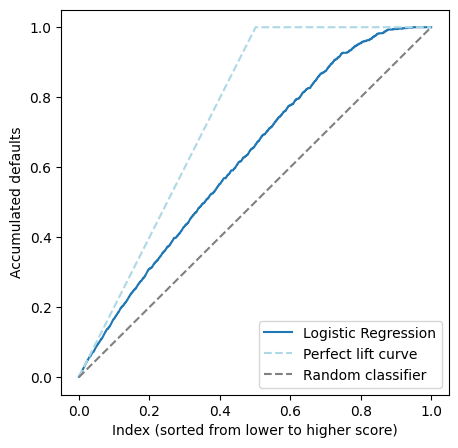

In [12]:
plt.subplots(figsize=(5,5))

# lift curve from the model
lift_lr.plot(label='Logistic Regression')

# perfect lift
ideal_lift_lr.plot(xlabel='Index (sorted from lower to higher score)', ylabel='Accumulated defaults', 
                       label='Perfect lift curve', linestyle='--', color='lightblue')

# random lift
x = np.linspace(0,1)
plt.plot(x,x, linestyle='--', label='Random classifier', color='gray')

plt.legend()
plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier


model_rf = RandomForestClassifier().fit(X_train,y_train)

In [14]:
y_train_pred_rf = model_rf.predict_proba(X_train)[:,1]
y_test_pred_rf = model_rf.predict_proba(X_test)[:,1]

In [15]:
print("Train ROC AUC: {0:.4f}".format(roc_auc_score(y_train, y_train_pred_rf)))
print("Test ROC AUC: {0:.4f}".format(roc_auc_score(y_test, y_test_pred_rf)))

Train ROC AUC: 1.0000
Test ROC AUC: 0.9713


In [16]:
lift_rf, ideal_lift_rf = build_lift_curve(y_test, 
                                    y_test_pred_rf, 
                                    ascending=False, 
                                    return_ideal_curve=True)

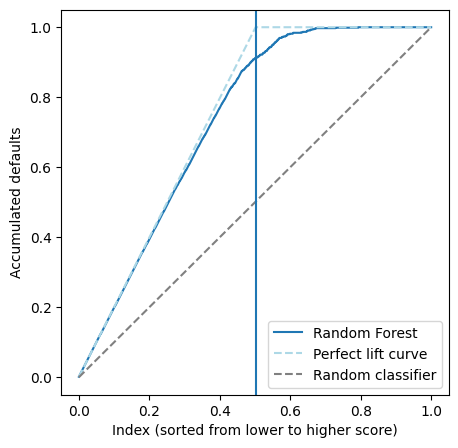

In [28]:
plt.subplots(figsize=(5,5))

# lift curve from the model
lift_rf.plot(label='Random Forest')

# perfect lift
ideal_lift_rf.plot(xlabel='Index (sorted from lower to higher score)', ylabel='Accumulated defaults', 
                       label='Perfect lift curve', linestyle='--', color='lightblue')

# random lift
x = np.linspace(0,1)
plt.plot(x,x, linestyle='--', label='Random classifier', color='gray')

plt.axvline(y_test.mean()) #Positive class prevalence


plt.legend()
plt.show()

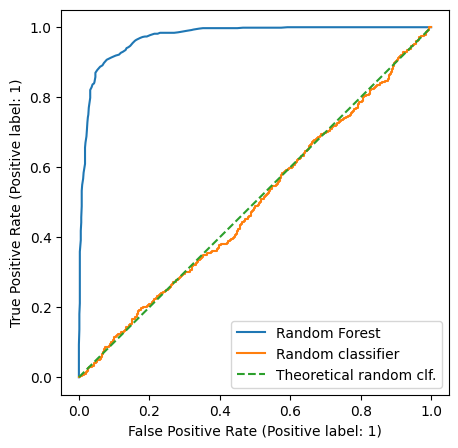

In [25]:
fig, ax = plt.subplots(figsize=(5,5))

# completely random classifier, generating random scores between [0,1]
np.random.seed(123)
y_pred_random = np.random.rand(*y_test_pred_rf.shape)

# theoretical random classifier
p = np.linspace(0,1)

RocCurveDisplay.from_predictions(y_test, y_test_pred_rf, ax=ax, label='Random Forest')
RocCurveDisplay.from_predictions(y_test, y_pred_random, ax=ax, label='Random classifier')
plt.plot(p,p,linestyle='--', label='Theoretical random clf.')
plt.legend()
plt.show()

In [19]:
from sklearn.dummy import DummyClassifier

In [20]:
model_dummy =DummyClassifier().fit(X_train,y_train)

In [21]:
y_train_pred_dummy = model_dummy.predict_proba(X_train)[:,1]
y_test_pred_dummy = model_dummy.predict_proba(X_test)[:,1]

In [22]:
print("Train ROC AUC: {0:.4f}".format(roc_auc_score(y_train, y_train_pred_dummy)))
print("Test ROC AUC: {0:.4f}".format(roc_auc_score(y_test, y_test_pred_dummy)))

Train ROC AUC: 0.5000
Test ROC AUC: 0.5000


In [23]:
lift_dummy, ideal_lift_dummy = build_lift_curve(y_test, 
                                    y_test_pred_dummy, 
                                    ascending=False, 
                                    return_ideal_curve=True)

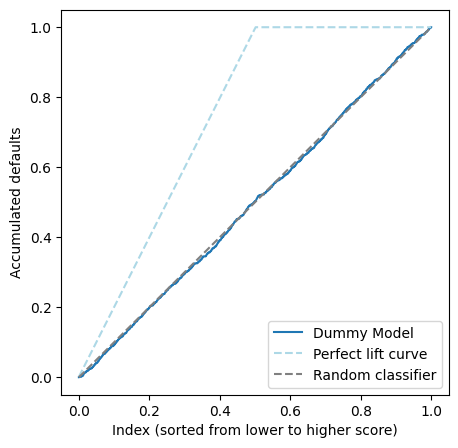

In [24]:
plt.subplots(figsize=(5,5))

# lift curve from the model
lift_dummy.plot(label='Dummy Model')

# perfect lift
ideal_lift_dummy.plot(xlabel='Index (sorted from lower to higher score)', ylabel='Accumulated defaults', 
                       label='Perfect lift curve', linestyle='--', color='lightblue')

# random lift
x = np.linspace(0,1)
plt.plot(x,x, linestyle='--', label='Random classifier', color='gray')


plt.legend()
plt.show()